### Author: Sophie Choe

#### Portland State University, Electrical and Computer Engineering
February 2022

Dependencies: keras-nightly==2.5.0.dev2021032900 PennyLane==0.17.0 StrawberryFields==0.18.0 tensorflow-2.4.0-cp38-cp38-macosx_10_9_x86_64.whl

# 3-qumode classifier: 10 classes

Classical layers using keras dense and quantum layers using Pennylane

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

import pennylane as qml
import numpy as np

import matplotlib.pyplot as plt

## 0. Loading data

Normalize pixel values from 0 ~ 255 to 0 ~ 1. 

In [2]:
mnist = keras.datasets.mnist

# datasets are numpy.ndarrays
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()     

# normalize the image data
X_train, X_test = X_train / 255.0, X_test / 255.0

One hot encode labels. The output vectors from the quantum circuit will be 3^3 = 27, where as the label vectors are of length 10. Hence enlarge label vectors to length 27 and pad them with 17 zeros.

In [3]:
def one_hot(labels):  
       
    depth = 3**3                       # 10 classes + 6 zeros for padding
    indices = labels.astype(np.int32)    
    one_hot_labels = np.eye(depth)[indices].astype(np.float32) 
    
    return one_hot_labels

# one-hot encoded labels, each label of length cutoff dimension**2
y_train, y_test = one_hot(Y_train), one_hot(Y_test)

# using only 600 samples for training in this experiment
n_samples = 600
test_samples = 100
X_train, X_test, y_train, y_test = X_train[:n_samples], X_test[:test_samples], y_train[:n_samples], y_test[:test_samples]

## 1. Classical circuit

Define classical layers using Keras Sequential. Take in 28x28 image matrices, flatten, and output vectors of length 22. 3 hidden layers with ELU activation.

In [2]:
keras.backend.set_floatx('float32')

model = keras.models.Sequential([
                                 layers.Flatten(input_shape = (28,28)),
                                 layers.Dense(128, activation ="elu"),
                                 layers.Dense(64, activation ="elu"),
                                 layers.Dense(32, activation ="elu"),
                                 layers.Dense(22, activation ="elu") 
                                ])

# More than a million parameters for the classical circuit
model.summary()

## 2. Data encoding circuit

Convert output vectors of the classical circuit into quantum states. Use the entries of the vectors as paratemeters of continuous variable gates.

In [5]:
def init_layer(x):
    qml.Squeezing(x[0], 0.0, wires=0)
    qml.Squeezing(x[1], 0.0, wires=1)
    qml.Squeezing(x[2], 0.0, wires=2)
    
    qml.Beamsplitter(x[3], x[4], wires=[0,1])
    qml.Beamsplitter(x[5], x[6], wires=[1,2])

    qml.Rotation(x[7], wires=0)
    qml.Rotation(x[8], wires=1)
    qml.Rotation(x[9], wires=2)
   
    qml.Displacement(x[10], 0.0, wires=0)
    qml.Displacement(x[11], 0.0, wires=1)
    qml.Displacement(x[12], 0.0, wires=2)
 
    qml.Kerr(x[13], wires=0)
    qml.Kerr(x[14], wires=1)
    qml.Kerr(x[15], wires=2)

## 3. Qauntum neural network circuit

Implementation of |activation(Wx+b)>. 
linear transformation W: Interferometer 1 (beamsplitters + rotation matrices), Squeezers, Interferometer 2 (beamsplitters + rotation matrices) 
Bias addition +b: Displacement gates
Activation function: Kerr gates

In [6]:
def layer(v):
    qml.Beamsplitter(v[0], v[1], wires=[0,1])
    qml.Beamsplitter(v[2], v[3], wires=[1,2])

    qml.Rotation(v[4], wires=0)
    qml.Rotation(v[5], wires=1)
    qml.Rotation(v[6], wires=2)

    qml.Squeezing(v[7], 0.0, wires=0)
    qml.Squeezing(v[8], 0.0, wires=1)
    qml.Squeezing(v[9], 0.0, wires=2)
    
    qml.Beamsplitter(v[10], v[11], wires=[0,1])
    qml.Beamsplitter(v[12], v[13], wires=[1,2])

    qml.Rotation(v[14], wires=0)
    qml.Rotation(v[15], wires=1)
    qml.Rotation(v[16], wires=2)

    qml.Displacement(v[17], 0.0, wires=0)
    qml.Displacement(v[18], 0.0, wires=1)
    qml.Displacement(v[19], 0.0, wires=2)

    qml.Kerr(v[20], wires=0)
    qml.Kerr(v[21], wires=1)
    qml.Kerr(v[22], wires=2)


## 4. Parameter initialization

The parameters to the quantum gates are initialized. These are to be optimized through training.

In [7]:
def init_weights(layers, modes, active_sd=0.0001, passive_sd=0.1):
    
    M = 4+3  # Number of interferometer parameters: 2 2-parameter beamsplitters + 3 rotations

    int1_weights = tf.random.normal(shape=[layers, M], stddev=passive_sd)
    s_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)
    int2_weights = tf.random.normal(shape=[layers, M], stddev=passive_sd)
    dr_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)
    k_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)

    weights = tf.concat([int1_weights, s_weights, int2_weights, dr_weights, k_weights], axis=1)
    weights = tf.Variable(weights)

    return weights

## 5. Quantum device

For the expression of qumodes in Fock basis, choose a "strawberryfields.fock" device. Define the number of qumodes and cutoff dimension. Run the data encoding circuit and quantum neural network circuit. The probability measurement method (qml.probs(wires)) returns vectors of size 3^3 = 27 (cutoff_dim^num_modes).

In [ ]:
num_modes = 3
num_basis = 3

dev = qml.device("strawberryfields.fock", wires=num_modes, cutoff_dim=num_basis) 

@qml.qnode(dev, interface="tf")
def quantum_nn(inputs, var):
    init_layer(inputs)            # Encode input x into quantum state

    for v in var:                 # iterative quantum layers
        layer(v)

    return qml.probs(wires=[0, 1, 2])  # Measurement 

## 6. Hybrid circuit

Construct a model circuit (classical + quantum) by converting the quantum layer to a Keras layer.

In [8]:
num_layers = 4

# initialize weights for quantum layers
weights = init_weights(num_layers, num_modes)

# Convert the quantum layer to a Keras layer
shape_tup = weights.shape
weight_shapes = {'var': shape_tup}
qlayer = qml.qnn.KerasLayer(quantum_nn, weight_shapes, output_dim = 4)

# Add to the classical sequential model
model.add(qlayer)

## 7. Loss and optimizer

Use Keras' built in loss function and optimizer for parameter updates.

In [ ]:
opt = keras.optimizers.SGD(lr = 0.03)
model.compile(opt, loss = 'categorical_crossentropy', metrics =['accuracy'])
model.summary()

## 8. Training

In [9]:
hybrid = model.fit(X_train, 
                   y_train,
                   epochs = 100,
                   batch_size = 64,
                   shuffle = True, 
                   validation_data = (X_test, y_test))

Epoch 1/100
10/10 [==============================] - 5608s 473s/step - loss: 3.3546 - accuracy: 0.1006 - val_loss: 2.0799 - val_accuracy: 0.2300
Epoch 2/100
10/10 [==============================] - 7212s 776s/step - loss: 2.0746 - accuracy: 0.2931 - val_loss: 2.0503 - val_accuracy: 0.3400
Epoch 3/100
10/10 [==============================] - 5043s 536s/step - loss: 1.9194 - accuracy: 0.4671 - val_loss: 1.7167 - val_accuracy: 0.5400
Epoch 4/100
10/10 [==============================] - 35711s 3942s/step - loss: 1.6625 - accuracy: 0.5672 - val_loss: 1.6558 - val_accuracy: 0.5800
Epoch 5/100
10/10 [==============================] - 3864s 403s/step - loss: 1.5560 - accuracy: 0.6202 - val_loss: 1.5710 - val_accuracy: 0.6400
Epoch 6/100
10/10 [==============================] - 4490s 475s/step - loss: 1.4570 - accuracy: 0.6860 - val_loss: 1.5156 - val_accuracy: 0.6800
Epoch 7/100
10/10 [==============================] - 2669s 270s/step - loss: 1.4122 - accuracy: 0.6804 - val_loss: 1.4843 - val_

In [ ]:
model.summary()

## 9. Loss and accuracy graphs

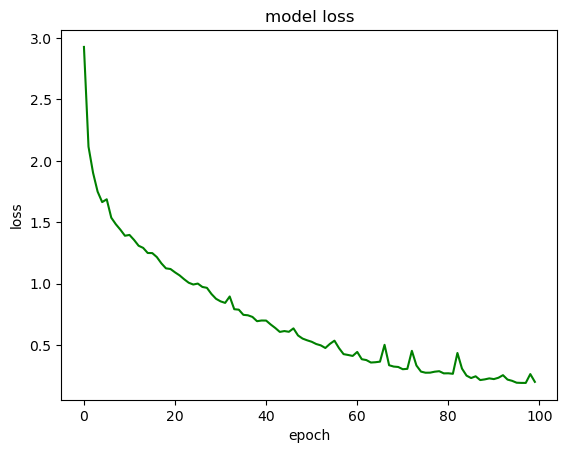

In [11]:
# ===================================================================================
#                                Loss History Plot
# ===================================================================================

plt.title('model loss')
plt.plot(hybrid.history['loss'], '-g')
plt.ylabel('loss')
plt.show()

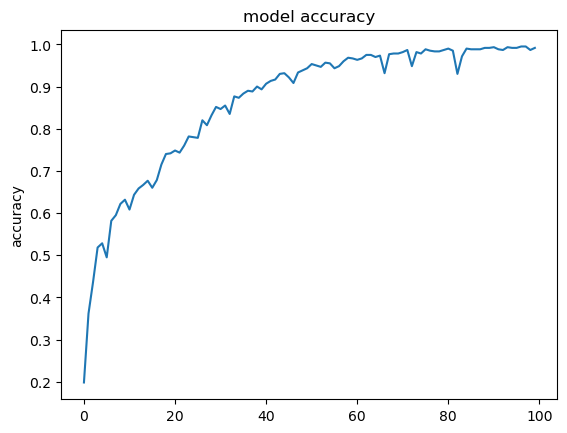

In [12]:
# ===================================================================================
#                                Accuracy History Plot
# ===================================================================================

plt.title('model accuracy')
plt.plot(hybrid.history['accuracy'])
plt.ylabel('accuracy')
plt.show()